# Libraries and Packages Import
There are 3 groups of import library and package used in this project.
- Utility: common library like numpy and pandas, etc.
- Text related: BeautifulSoup for parser HTML 、 nltk for processing text and te for text emotion.
- Sklearn: machine learning packages as previous labs and lectures.

In [1]:
%matplotlib inline
# util
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange

# text related
import re
from bs4 import BeautifulSoup
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import text2emotion as te

# sklearn
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.impute import SimpleImputer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Che\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Che\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Che\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Custom Defined Functions and Classes

We defined the following functions to simply compute attribute information we need. 

In [2]:
import nltk
from nltk import word_tokenize

def count_words(text):
    return len(text.split())

def count_words_in_quotes(text):
    x = re.findall("'.'|\".\"", text)
    count=0
    if x is None:
        return 0
    else:
        for i in x:
            t=i[1:-1]
            count+=count_words(t)
        return count

def count_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

def count_sentence(text):
    x = re.split(r'[.!?]+', text)
    return len(x) - 1

## Data Pre-processing Function: conducts the major part of data pre-processing.
We use BeautifulSoup to extract specific html tags and tune different attributes in the 'Tuning Attribute' part. In 'Time' session, we do a trivial transformation first to divide the values of weekday and month into binary groups. In 'Emotion' session, because <i>te.get_motion(text)</i> would return a set of emotion value of text, for example, 
<code>{'Angry': 0.12, 'Fear': 0.42, 'Happy': 0.04, 'Sad': 0.33, 'Surprise': 0.08}.</code> Accordingly, we sum up square value of each emotion to output an overall emotion value which represents the emotion degree of the text. In 'Channel' section, we find that some attributes are actually redudant, which means they will not influence final predict. After some experiments, we pick 6 type of channel <code>{"is_lifestyle", "is_entertainment", "is_bus", "is_socmed", "is_tech", "is_world"}</code>from 33 type and give it binary label. (1 for positive, 0 for negative) 

Finally, return a dictionary after processing all values.

In [8]:
def data_preprocess(text):
    bs = BeautifulSoup(text, 'html.parser')
    
    title = bs.find(class_="title").text
    content = bs.find(class_="article-content").text
    channel = bs.find("article")["data-channel"]
    # tag = bs.find(class_="article-topics").text
    # match = re.compile('Topics:')
    # tag = match.sub(r' ', tag)
    topic_tags = bs.find('footer', class_="article-topics").find_all('a')
    topics = [t.get_text() for t in topic_tags]
    tag = ' '.join(topics)
    fig_count = len(bs.find_all('img'))
    link_count = len(bs.find_all('a'))

    ### Tuning Attribute
    # word_count = len(text.split())
    # capital_word_count = sum(map(str.isupper,text.split()))
    sentence_count = count_sentence(text)
    # unique_word_count = len(set(text.split()))
    # htags_count = re.findall(r'(#w[A-Za-z0-9]*)', text)
    words_in_quotes_count = count_words_in_quotes(text)
    # stopwords_count = count_stopwords(text)
    
    # Time
    time = bs.find('time')
    timestamp, weekday, month = np.NaN, np.NaN, np.NaN
    if time.has_attr('datetime'):
        time = datetime.strptime(time['datetime'], '%a, %d %b %Y %H:%M:%S %z')
        weekday = 0 if time.weekday() > 4 else 1
        month = 1 if time.month > 5 else 0
        timestamp = time.timestamp()

    # Emotion
    emo_val = 0
    for v in list(te.get_emotion(title).values()):
        if type(v)==int:
            break
        emo_val += v**2 if v!=0 else 0

    # Major channel: Lifestyle、Entertainment、Business、Social Media、Tech、World
    is_lifestyle = 1 if channel == 'lifestyle' else 0
    is_entertainment = 1 if channel == 'entertainment' else 0
    is_bus = 1 if channel == 'bus' else 0
    is_socmed = 1 if channel == 'socmed' else 0
    is_tech = 1 if channel == 'tech' else 0
    is_world = 1 if channel == 'world' else 0

    return {
            "title": title, 
            "content": content,
            "tag":  tag,
            "channel": channel, 
            "fig_count":  fig_count,
            "link_count":  link_count,
            "weekday":  weekday,
            "month": month,
            "timestamp":  timestamp,
            "word_count": words_in_quotes_count,
            "sentence_count": sentence_count,
            "emo_val": emo_val,
            "is_lifestyle": is_lifestyle,
            "is_entertainment": is_entertainment,
            "is_bus": is_bus,
            "is_socmed": is_socmed,
            "is_tech": is_tech,
            "is_world": is_world
            }

# data_preprocess(df.loc[0,'Page content'])

The following functions are copied from TA's notebook.

In [4]:
def preprocessor(text):
    """
    - remove HTML tags
    - remove punctuation
    - convert to lowercase
    """
    text = text#[0]
    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)
    
    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text

In [5]:
nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    """
    - tokenization
    - word-stemming
    - remove stop-word
    """
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Che\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Pre-processing

In [9]:
attribute = ["title", "content", "tag",
            "channel", "fig_count", "link_count",
            "weekday", "month", "timestamp",
            "word_count", "sentence_count", "emo_val", 
            "is_lifestyle", "is_entertainment", "is_bus", "is_socmed", "is_tech", "is_world"]
df = pd.read_csv('../data/train.csv')
df.head()

,Id,Popularity,Page content
0,0,-1,"<html><head><div class=""article-info""> <span c..."
1,1,1,"<html><head><div class=""article-info""><span cl..."
2,2,1,"<html><head><div class=""article-info""><span cl..."
3,3,-1,"<html><head><div class=""article-info""><span cl..."
4,4,-1,"<html><head><div class=""article-info""><span cl..."


In [10]:
nltk.download('punkt')
nltk.download('stopwords')

train_data = pd.DataFrame(columns=attribute)
train_label = pd.DataFrame(columns=["Popularity"])
for i in trange(len(df)):
    train_data = train_data.append(data_preprocess(df.loc[i,'Page content']), ignore_index=True)
    train_label = train_label.append({"Popularity": df.loc[i, "Popularity"]}, ignore_index=True)
    
train_data.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Che\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Che\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 27643/27643 [32:09<00:00, 14.32it/s]


,title,content,tag,channel,fig_count,link_count,weekday,month,timestamp,word_count,sentence_count,emo_val
0,NASA's Grand Challenge: Stop Asteroids From De...,There may be killer asteroids headed for Eart...,Asteroid Asteroids challenge Earth Space U.S. ...,world,1,22,1,1,1.371654e+09,1,84,0.500
1,Google's New Open Source Patent Pledge: We Won...,Google took a stand of sorts against patent-l...,Apps and Software Google open source opn pledg...,tech,2,18,1,0,1.364492e+09,1,54,0.625
2,Ballin': 2014 NFL Draft Picks Get to Choose Th...,You've spend countless hours training to be a...,Entertainment NFL NFL Draft Sports Television,entertainment,2,11,1,0,1.399490e+09,26,300,0.000
3,Cameraperson Fails Deliver Slapstick Laughs,Tired of the same old sports fails and ne...,Sports Video Videos Watercooler,watercooler,1,13,1,1,1.381458e+09,21,214,0.000
4,NFL Star Helps Young Fan Prove Friendship With...,"At 6-foot-5 and 298 pounds, All-Pro NFL star ...",Entertainment instagram instagram video NFL Sp...,entertainment,52,16,1,0,1.397706e+09,3,691,0.250


In [21]:
# Encoding non-numerical column
label_le = LabelEncoder()
train_data["channel"] = label_le.fit_transform(train_data["channel"].values)

X_train, X_test, y_train, y_test = train_test_split(train_data.drop(columns=['title','content', 'tag']), train_label['Popularity'].astype('int'),
                                                    test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
X_train.head()

(22114, 9) (22114,)
(5529, 9) (5529,)


,channel,fig_count,link_count,weekday,month,timestamp,word_count,sentence_count,emo_val
3492,3,2,15,1,1,1.383328e+09,2,40,0.5000
9375,3,2,8,1,1,1.409834e+09,2,45,0.0000
17129,20,1,14,1,1,1.387937e+09,1,58,0.5578
27200,31,1,15,1,1,1.413211e+09,1,33,0.0000
22507,28,21,39,0,0,1.358004e+09,1,352,1.0000


# Models

## Basic Model
In the basic model, we drop the text columns including 'title', 'content', and 'tag' for convinence. We use a pipeline with StandardScalar, SimpleImputer, RandomForestClassifier as our estimator and tune different value of hyperparameters on random forest classifier.

In [10]:
# param
param_est = [50, 200, 500, 800]
param_depth = [2, 5, 10, 15]
param_grid = [{'clf__n_estimators': param_est, 
               'clf__max_depth': param_depth}]

pipe = Pipeline([ 
                    ('sc', StandardScaler()),
                    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
                    ('clf', RandomForestClassifier(n_jobs=-1, random_state=1))
                ])

gs = GridSearchCV(
    estimator = pipe, 
    param_grid = param_grid, 
    scoring = 'roc_auc',
    cv = 10
)

gs = gs.fit(X_train, y_train)
print('[RF: grid search]')
print('Validation roc_auc score: %.3f' % gs.best_score_)
print(gs.best_params_)

best_clf = gs.best_estimator_

[SVC: grid search]
Validation roc_auc score: 0.588
{'clf__max_depth': 10, 'clf__n_estimators': 500}


## Text + Numerical Model (Best Model)
In this model, we use both text and numerical features. Process each feature and combine into a high dimensional input. Use random forest as classifier.

In [79]:
tmpx_train, tmpx_test, tmpy_train, tmpy_test = train_test_split(train_data.drop(columns=['content']), train_label['Popularity'].astype('int'),
                                                    test_size=0.2, random_state=0)
tmpx_train.head()

,title,tag,channel,fig_count,link_count,weekday,month,timestamp,word_count,sentence_count,emo_val
3492,Analyst: iPad Air Sales May Top 3 Million This...,Apple Business Gadgets iPad iPad Air iPad Mini...,3,2,15,1,1,1.383328e+09,2,40,0.5000
9375,Vice Raises $500 Million in Its Quest for 'Tot...,Business Media VICE Media,3,2,8,1,1,1.409834e+09,2,45,0.0000
17129,Twitter Shares Soar to Record on Optimism for ...,Advertising Business Mobile Twitter,20,1,14,1,1,1.387937e+09,1,58,0.5578
27200,John Oliver Is Leading the War Against Pumpkin...,Coffee John Oliver Last Week Tonight With John...,31,1,15,1,1,1.413211e+09,1,33,0.0000
22507,10 Top News Stories This Week,CES Tech,28,21,39,0,0,1.358004e+09,1,352,1.0000


In [80]:
param_est = [500, 1000, 1500]
param_depth = [15]
param_grid = [{'clf__n_estimators': param_est, 
               'clf__max_depth': param_depth}]
param_grid

[{'clf__n_estimators': [500, 1000, 1500], 'clf__max_depth': [15]}]

In [81]:
from sklearn.compose import ColumnTransformer

numeric_features = ['channel', 'fig_count', 'link_count',
                    'weekday', 'month', 'timestamp', 
                    'word_count', 'sentence_count', 'emo_val', 
                    "is_lifestyle", "is_entertainment", "is_bus", "is_socmed", "is_tech", "is_world"]
numeric_transformer = Pipeline([ 
                                ('sc', StandardScaler()),
                                ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent'))
                            ])

# tf = TfidfVectorizer(preprocessor=preprocessor, tokenizer=tokenizer_stem_nostop)
tf = HashingVectorizer(n_features=2**3,
                        preprocessor=preprocessor,
                        tokenizer=tokenizer_stem_nostop)
text_trans = tf.fit_transform(tmpx_train['tag']).toarray()
text_trans_2 = tf.fit_transform(tmpx_train['title']).toarray()

col_preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features)])
num_trans = col_preprocessor.fit_transform(tmpx_train)

# Mix text & numeric
tmpx_train = np.hstack((text_trans, text_trans_2, num_trans))
print("x_train shape:", tmpx_train.shape)

pipe = Pipeline([('clf', RandomForestClassifier(n_jobs=-1, random_state=1))])

gs = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid, 
    scoring = 'roc_auc',
    cv = 10
)

gs = gs.fit(tmpx_train, tmpy_train)
print('[SVC: grid search]')
print('Validation roc_auc score: %.3f' % gs.best_score_)
print(gs.best_params_)

best_clf = gs.best_estimator_

C:\Users\Che\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


x_train shape: (22114, 25)
[SVC: grid search]
Validation roc_auc score: 0.587
{'clf__max_depth': 15, 'clf__n_estimators': 1000}


## Try channel
This block is to see whether 'channel' attribute affect the performance or not.
In the following bar chart, we can find lots of redundant information in all channel type 

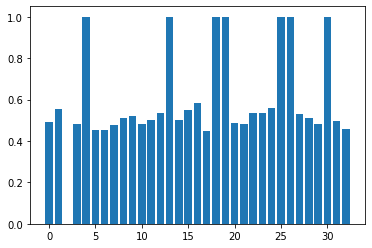

In [52]:
channel_num = np.zeros((33, 2))
for i in range(len(train_data)):
    c = train_data['channel'][i]
    channel_num[c][(train_label['Popularity'][i] + 2) // 2] += 1
sort_idx = np.argsort(np.sum(channel_num, axis=1))
pop = channel_num[:,1] / np.sum(channel_num, axis=1)
plt.bar(range(33), pop)
plt.show()

In [3]:
tmp_sum = 0
thre = 0.08
for i in range(33):
    if pop[i] > 0.5+thre or pop[i] < 0.5-thre:
        print(f"Channel[{i:2d}]: {channel_num[i]}")
        tmp_sum += np.sum(channel_num[i])
print("# of data w/ significant impact: ", tmp_sum)

Channel[ 2]: [1. 0.]
Channel[ 4]: [0. 1.]
Channel[13]: [0. 1.]
Channel[16]: [164. 229.]
Channel[18]: [0. 2.]
Channel[19]: [0. 2.]
Channel[25]: [0. 2.]
Channel[26]: [0. 6.]
Channel[30]: [0. 1.]
# of data w/ significant impact: 409.0


The number of data with significant impact accounts for little proportion. It seems that there is almost no influence on the performance.

## Test the Best Model
Test our best model on validation data and show the ROC curve.

C:\Users\Che\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Validation Accuracy: 0.5630
AUC: 0.5860


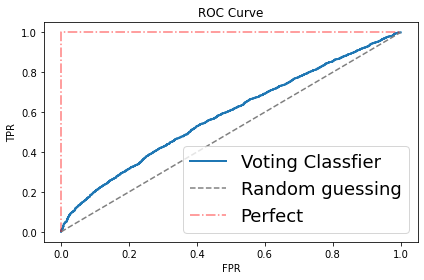

In [82]:
# Best Model
text_trans = tf.fit_transform(tmpx_test['tag']).toarray()
text_trans_2 = tf.fit_transform(tmpx_test['title']).toarray()
num_trans = col_preprocessor.fit_transform(tmpx_test)

tmpx_test = np.hstack((text_trans, text_trans_2, num_trans))

X_test = tmpx_test
y_test = tmpy_test

proba = best_clf.predict_proba(X_test)
y_pred = best_clf.predict(X_test)
print('Validation Accuracy: %.4f' % accuracy_score(y_test, y_pred))
# Use feature 1 as positive label
fpr, tpr, thresholds = roc_curve(y_test,
                                 proba[:, 1],
                                pos_label=1)
print('AUC: %.4f' % auc(fpr, tpr))


plt.plot(fpr, tpr, lw=2, label='Voting Classfier')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guessing')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='-.', alpha=0.5, color='red', label='Perfect')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.legend(loc=4, prop={'size': 18})
plt.show()

# Testing and Output

In [11]:
df_real = pd.read_csv('../data/test.csv')

test_data = pd.DataFrame(columns=attribute)
for i in trange(len(df_real)):
    test_data = test_data.append(data_preprocess(df_real.loc[i,'Page content']), ignore_index=True)
    
label_le = LabelEncoder()
test_data["channel"] = label_le.fit_transform(test_data["channel"].values)
test_data.head()


100%|██████████| 11847/11847 [12:22<00:00, 15.96it/s]


,title,content,tag,channel,fig_count,link_count,weekday,month,timestamp,word_count,sentence_count,emo_val
0,Soccer Star Gets Twitter Death Threats After T...,Note to humanity: One Direction fandom ai...,Entertainment Music One Direction soccer Sports,5,1,30,1,1,1.378756e+09,8,128,0.5578
1,Google Glass Gets an Accessory Store,Shortly after announcing a hardware upgrade f...,Gadgets glass Google Google Glass Google Glass...,25,3,13,1,1,1.383212e+09,2,44,0.0000
2,OUYA Gaming Console Already Sold Out on Amazon,"Well, that was quick. Just hours after going ...",amazon amazon kindle Business Gaming,2,2,13,1,1,1.372165e+09,1,40,1.0000
3,'Between Two Ferns' Mocks Oscar Nominees,Between Two Ferns: Oscar Buzz Edition Part 1...,Between Two Ferns Movies The Oscars Oscars 201...,6,1,15,1,0,1.360726e+09,4,41,0.0000
4,'American Sniper' Trailer: Looks Like Eastwood...,Ever since The Hurt Locker it seems like ...,American Sniper Awards Bradley Cooper clint ea...,5,1,10,1,1,1.412300e+09,1,28,1.0000


In [83]:
# Run first if choose the second model(text+num)

all_train = train_data.drop(columns=['content'])
text_trans = tf.fit_transform(all_train['tag']).toarray()
text_trans_2 = tf.fit_transform(all_train['title']).toarray()
num_trans = col_preprocessor.fit_transform(all_train)

all_train = np.hstack((text_trans, text_trans_2, num_trans))
print("Train shape:", all_train.shape)

all_test = test_data.drop(columns=['content'])
text_trans = tf.fit_transform(all_test['tag']).toarray()
text_trans_2 = tf.fit_transform(all_test['title']).toarray()
num_trans = col_preprocessor.fit_transform(all_test)

all_test = np.hstack((text_trans, text_trans_2, num_trans))
print("Test shape:", all_test.shape)

C:\Users\Che\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Train shape: (27643, 25)


C:\Users\Che\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Test shape: (11847, 25)


In [84]:
'''
Basic model: all_train/test -> train/test_data.drop(columns=[])
Text+Numerical model: run above block first
'''

best_clf.fit(all_train, train_label['Popularity'].astype('int'))
result = best_clf.predict_proba(all_test)
out = pd.DataFrame({'Id': df_real.Id, 'Popularity': result[:, 1]})
out.to_csv('./output/predict.csv', index=False)
print(out)

          Id  Popularity
0      27643    0.410812
1      27644    0.489053
2      27645    0.402413
3      27646    0.464574
4      27647    0.445739
...      ...         ...
11842  39485    0.801128
11843  39486    0.494128
11844  39487    0.544063
11845  39488    0.457916
11846  39489    0.476914

[11847 rows x 2 columns]


# Conclusion

## Experiment Result
|| Validation Score | Kaggle Public Score | Kaggle Private Score |
| ---- | :----: | :----: | :----: |
|Basic Model w/o 'emo_val'|0.572|0.57219|0.57413|
|Basic Model w/ 'emo_val'|0.5841|0.57646|0.57639|
|Best Model w/o 'channel'|0.5848|<b>0.58640</b>|0.58315|
|Best Model w/ 'channel'|<b>0.5867</b>|0.58387|<b>0.58414</b>|

- Basic Model: Use numerical features only.
- Best Model: Use both text and numerical features.
- Final features used: 
    - Text: 'title': 8-D, 'tag': 8-D
    - Numeric: 'channel', 'fig_count', 'link_count', 'weekday', 'month', 'timestamp', 'word_count', 'sentence_count', 'emo_val', 'is_lifestyle', 'is_entertainment', 'is_bus', 'is_socmed', 'is_tech', 'is_world'

## Opinion
- In Time information, the most useful features are "Weekday" and "Month". It is one of the easist way to beyond the 60 baseline.
- Combine Texture and Numerical Features for training can improve performance obviously. 
- Sometimes, the higher public score means overfitting so maybe cause worst private score as expected.
- Maybe next time we can submit different model to kaggle, rather than depend on validation score.